# Counterfactuals<br>


## Random forest model


<div>Train a Random Forest model to be used as `PredictionProvider` by the Counterfactuals (CF).<br></div>


In [1]:
import ml.smile.data.Loader
import smile.data.{DataFrame, Tuple}

We will use the *credit bias* dataset in the notebook. We will also restrict our model to two inputs (`Amount` and `LoanDuration`) and one output (`PaidLoan`) for easier visualisation.<br>

In [3]:
val df = Loader.csv(Loader.homeRelativePath("data/credit_bias-train.csv").toString)
val subset: DataFrame = df.select("Amount", "LoanDuration", "PaidLoan")

In [4]:
subset.summary

[column: String, count: long, min: double, avg: double, max: double]
+------------+-----+----+-----------+-----+
|      column|count| min|        avg|  max|
+------------+-----+----+-----------+-----+
|      Amount|58003|6.39|2242.612586|10632|
|LoanDura…

We will also use the range of the inputs as the search boundaries for the counterfactual search.

Let's train a Smile random forest with the default settings.<br>




In [6]:
import smile.data.formula.Formula
import smile.classification.RandomForest
import smile.data.`type`.{DataTypes, StructField}

val formula: Formula = Formula.lhs("PaidLoan")
val model = RandomForest.fit(formula, subset)

## Decision boundaries<br>



We create a result grid in order to visualise the **decision boundaries**.<br>

In [9]:
val schema = DataTypes.struct(new StructField("Amount", DataTypes.DoubleType), new StructField("LoanDuration", DataTypes.DoubleType))

val predictions = Array.tabulate(10000,60)((amount, loanDuration) => {
    val input = DataFrame.of(Array(Array(amount, loanDuration)), "Amount", "LoanDuration")
    model.predict(input)(0)
})

We can now plot the values (yellow for paid loan, purple for unpaid loan).<br>

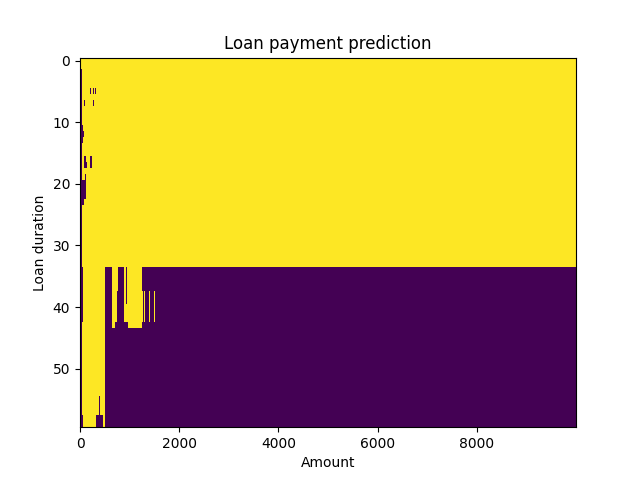

In [11]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

plt.imshow(np.array(predictions).transpose(), aspect='auto', interpolation='none')
plt.xlabel("Amount")
plt.ylabel("Loan duration")
plt.title("Loan payment prediction")
plt.show()

## Counterfactual search

<div><h3>Example 1<br></h3></div>

<div>Just for the sake of visualisation, let's restrict the view to loan amounts up to $500 and loan durations up to 30 months.</div><div>We will also pick a point of `amount=50` and `duration=22`, which the model will classify as "will not be paid".<br></div>

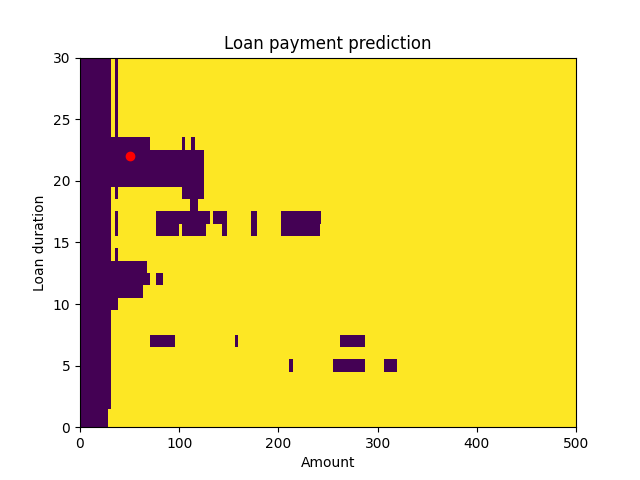

In [14]:
plt.imshow(np.array(predictions).transpose(), aspect='auto', interpolation='none')
plt.scatter(50,22,color='r')
plt.xlim(0, 500)
plt.ylim(0, 30)
plt.xlabel("Amount")
plt.ylabel("Loan duration")
plt.title("Loan payment prediction")
plt.show()

We now search for a counterfactual for this application.<br>




In [16]:
import ml.trusty.Counterfactual
import org.kie.kogito.explainability.model._
import org.kie.kogito.explainability.model.domain.NumericalFeatureDomain
import smile.classification.RandomForest
import smile.data.DataFrame
import smile.data.formula.Formula
import ml.smile.providers.RandomForestProvider

val goal = List(new Output("PaidLoan", Type.NUMBER, new Value(1.0), 0.0d))

val features = List(
    FeatureFactory.newNumericalFeature("Amount", 50),
    FeatureFactory.newNumericalFeature("LoanDuration", 22),
)
val constraints = List(false, false)
val domains = List(
    NumericalFeatureDomain.create(0.0, 500.0),
    NumericalFeatureDomain.create(0.0, 30.0))

val randomForest = new RandomForestProvider(model)

val counterfactual = new Counterfactual(randomForest, steps=300_000)
val result = counterfactual.explain(goal, features, domains, constraints)

In [17]:
val point = Array(
    result.getEntities.get(0).asFeature.getValue.asNumber,
    result.getEntities.get(1).asFeature.getValue.asNumber
)

We can the CF returns a loan application with a slightly longer duration in order to be classified as "will pay".




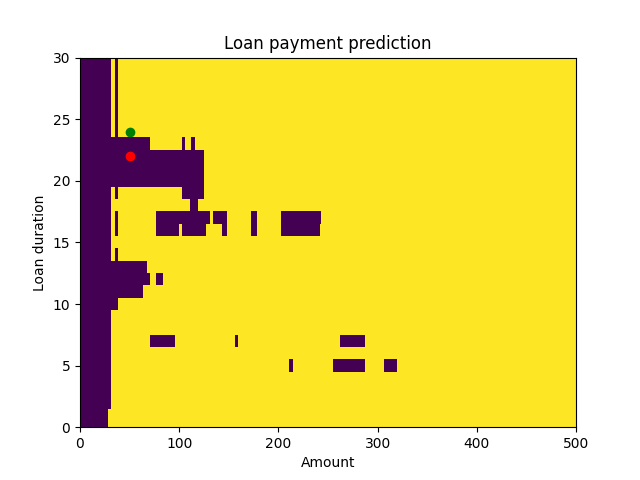

In [19]:
plt.imshow(np.array(predictions).transpose(), aspect='auto', interpolation='none')
plt.scatter(50,22,color='r')
plt.scatter(point[0],point[1],color='g')
plt.xlim(0, 500)
plt.ylim(0, 30)
plt.xlabel("Amount")
plt.ylabel("Loan duration")
plt.title("Loan payment prediction")
plt.show()

### Example 2

<div>We will search for a counterfactual in an area further away from the decision boundary in the `amount=9000`, `duration=59` area.<br></div>

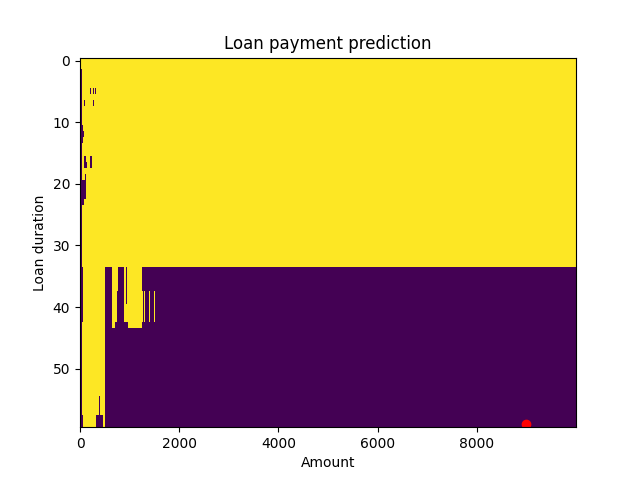

In [21]:
plt.imshow(np.array(predictions).transpose(), aspect='auto', interpolation='none')
plt.scatter(9000, 59, color='r')
plt.xlabel("Amount")
plt.ylabel("Loan duration")
plt.title("Loan payment prediction")
plt.show()

In [22]:
val features = List(
    FeatureFactory.newNumericalFeature("Amount", 9000),
    FeatureFactory.newNumericalFeature("LoanDuration", 59),
)
val domains = List(
    NumericalFeatureDomain.create(0.0, 9500.0),
    NumericalFeatureDomain.create(0.0, 60.0))

val result = counterfactual.explain(goal, features, domains, constraints)

In [23]:
val point = Array(
    result.getEntities.get(0).asFeature.getValue.asNumber,
    result.getEntities.get(1).asFeature.getValue.asNumber
)

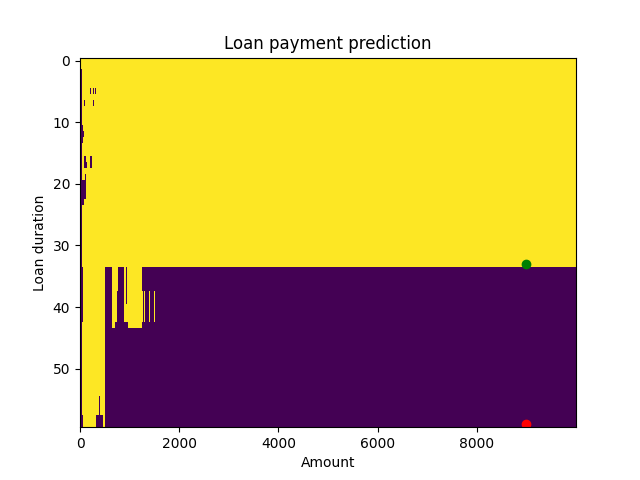

In [24]:
plt.imshow(np.array(predictions).transpose(), aspect='auto', interpolation='none')
plt.scatter(9000, 59, color='r')
plt.scatter(point[0],point[1],color='g')
plt.xlabel("Amount")
plt.ylabel("Loan duration")
plt.title("Loan payment prediction")
plt.show()

## KNN model

<div>Let's simulated a 2-$d$ dataset with 3 clusters.</div>

In [26]:
from sklearn.datasets import make_blobs
import pandas as pd

X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,0), (0, 5), (5, 0)])
blobs = pd.DataFrame(data=X, columns=["x", "y"])
blobs['cluster'] = y
blobs.to_csv("/tmp/blobs.csv", index=False)

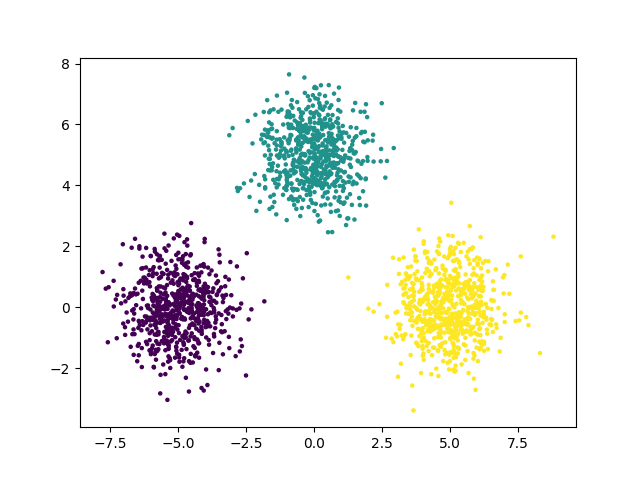

In [29]:
plt.scatter(blobs.x, blobs.y, c=blobs.cluster, s=5)
plt.show()

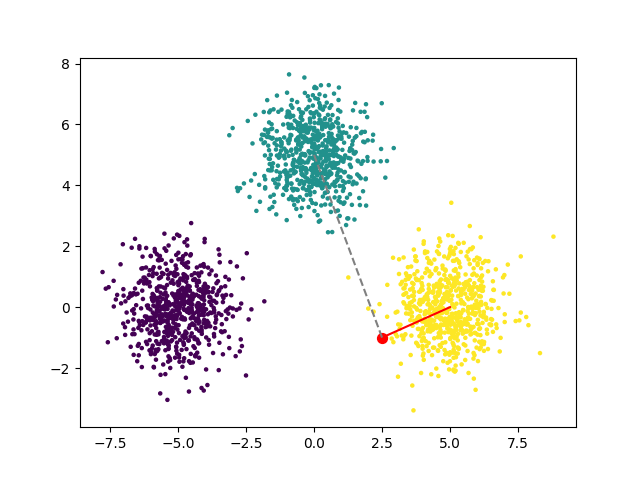

In [33]:
ORIGINAL = [2.5, -1.0]
plt.scatter(blobs.x, blobs.y, c=blobs.cluster, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.plot([ORIGINAL[0], 5], [ORIGINAL[1], 0], c="red")
plt.plot([ORIGINAL[0], 0], [ORIGINAL[1], 5], c="grey", linestyle="dashed")
plt.show()

In [27]:
import smile.classification.KNN

val blob_df = Loader.csv("/tmp/blobs.csv")

val x = blob_df.select("x", "y").toArray
val y = blob_df.select("cluster").toArray.map(y => y(0).toInt)

val model = KNN.fit(x, y)

In [30]:
import ml.smile.providers.KNNProvider

val goal = List(new Output("cluster", Type.NUMBER, new Value(1), 0.0d))

val features = List(
    FeatureFactory.newNumericalFeature("x", 2.5),
    FeatureFactory.newNumericalFeature("y", -1.0),
)
val constraints = List(false, false)
val domains = List(
    NumericalFeatureDomain.create(-10.0, 10.0),
    NumericalFeatureDomain.create(-10.0, 10.0))

val provider = new KNNProvider(blob_df.select("x", "y"), blob_df.select("cluster"))

val counterfactual = new Counterfactual(provider, steps=300_000)
val result = counterfactual.explain(goal, features, domains, constraints)

In [31]:
val point = Array(
    result.getEntities.get(0).asFeature.getValue.asNumber,
    result.getEntities.get(1).asFeature.getValue.asNumber
)

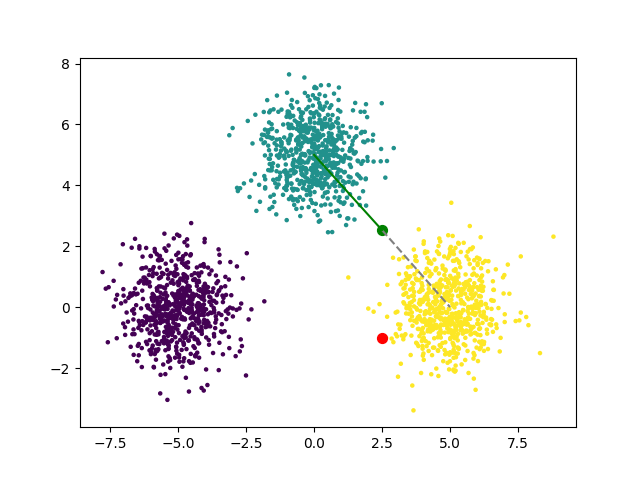

In [32]:
ORIGINAL = [2.5, -1.0]
plt.scatter(blobs.x, blobs.y, c=blobs.cluster, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.scatter(point[0], point[1], c="green", s=50)
plt.plot([point[0], 5], [point[1], 0], c="grey", linestyle="dashed")
plt.plot([point[0], 0], [point[1], 5], c="green")

plt.show()

In [28]:
{"type":"table","value":"Out","rowRange":[0,10]}